In [1]:
#Importing Modules

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import os
import tqdm
import random
from keras.preprocessing.image import load_img
warnings.filterwarnings('ignore')

In [3]:
#Creating Dataframe for input and output

In [4]:
input_path=[]
label=[]
base_dir = r"D:\Projects ML\Dog Vs Cats Classifire Proj 6\PetImages"

for class_name in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_name)
    
    for path in os.listdir(class_path):
        if class_name == 'Cat':
            label.append(0)
        else:
            label.append(1)
        
        input_path.append(os.path.join(class_path, path))

print(input_path[0], label[0])

D:\Projects ML\Dog Vs Cats Classifire Proj 6\PetImages\Cat\0.jpg 0


In [5]:
len(input_path)

25002

In [6]:
df = pd.DataFrame()
df['images']=input_path
df['label']=label
df=df.sample(frac=1).reset_index(drop=True)
df['label']=df['label'].astype('str')
df.head()

,images,label
0,D:\Projects ML\Dog Vs Cats Classifire Proj 6\P...,1
1,D:\Projects ML\Dog Vs Cats Classifire Proj 6\P...,1
2,D:\Projects ML\Dog Vs Cats Classifire Proj 6\P...,0
3,D:\Projects ML\Dog Vs Cats Classifire Proj 6\P...,0
4,D:\Projects ML\Dog Vs Cats Classifire Proj 6\P...,1


In [7]:
#Deelete DB  files
for i in df['images']:
    if '.jpg' not in i:
        print(i)

D:\Projects ML\Dog Vs Cats Classifire Proj 6\PetImages\Cat\Thumbs.db
D:\Projects ML\Dog Vs Cats Classifire Proj 6\PetImages\Dog\Thumbs.db


In [8]:
import PIL
from PIL import Image

bad_images = []

for image in df['images']:
    try:
        img = Image.open(image)
        img.verify()  # make sure image is not corrupted
    except Exception as e:
        bad_images.append(image)

# remove bad files from df
df = df[~df['images'].isin(bad_images)]

# also remove known junk files (Thumbs.db)
df = df[~df['images'].str.contains('Thumbs.db', case=False, na=False)]

print(f"Removed {len(bad_images)} corrupted images.")
print(f"Remaining images: {len(df)}")


Removed 4 corrupted images.
Remaining images: 24998


In [9]:
#EDA

In [10]:
#Display Grid of images
plt.figure(figsize=(25,25))
temp = df[df['label']==1]['images']
start = random.randint(0,len(temp))
files = temp[start:start+25]

for index, file in enumerate(files):
    plt.subplot(5,5,index+1)
    img = load_img(file)
    img=np.array(img)
    plt.imshow(img)
    plt.title("Dogs")
    plt.axis('off')

<Figure size 2500x2500 with 0 Axes>

In [11]:
#Display Grid of images
plt.figure(figsize=(25,25))
temp = df[df['label']==0]['images']
start = random.randint(0,len(temp))
files = temp[start:start+25]

for index, file in enumerate(files):
    plt.subplot(5,5,index+1)
    img = load_img(file)
    img=np.array(img)
    plt.imshow(img)
    plt.title("Cats")
    plt.axis('off')

<Figure size 2500x2500 with 0 Axes>

In [12]:
#input split
from sklearn.model_selection import train_test_split
train,test=train_test_split(df,test_size=0.2,random_state=42) 

In [13]:
# Create Data generator for Images
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    rescale = 1./255, #Normalisation of images
    rotation_range = 40,#Augmentation of images to avoid overfitting
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

val_generator = ImageDataGenerator(
    rescale=1./255
)

train_iterator=train_generator.flow_from_dataframe(
    train,
    x_col='images',
    y_col='label',
    target_size=(128,128),
    batch_size=512,
    class_mode='binary'
)

val_iterator=val_generator.flow_from_dataframe(
    test,
    x_col='images',
    y_col='label',
    target_size=(128,128),
    batch_size=512,
    class_mode='binary'
)

Found 19998 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [14]:
#Model Creation

In [15]:
from keras import Sequential 
from keras.layers import Conv2D,MaxPool2D,Flatten,Dense

model=Sequential([
    Conv2D(16,(3,3),activation='relu',input_shape=(128,128,3)),
    MaxPool2D((2,2)),
    Conv2D(32,(3,3),activation='relu'),
    MaxPool2D((2,2)),
    Conv2D(64,(3,3),activation='relu'),
    MaxPool2D((2,2)),
    Flatten(),
    Dense(512,activation='relu'),
    Dense(1,activation='sigmoid')
])


In [16]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       6,423,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,447,137 (24.59 MB)

 Trainable params: 6,447,137 (24.59 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history=model.fit(train_iterator,epochs=50,validation_data=val_iterator)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 153s 4s/step - accuracy: 0.5227 - loss: 0.7746 - val_accuracy: 0.5864 - val_loss: 0.6770
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 151s 4s/step - accuracy: 0.6159 - loss: 0.6560 - val_accuracy: 0.6702 - val_loss: 0.6277
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 153s 4s/step - accuracy: 0.6686 - loss: 0.6095 - val_accuracy: 0.7036 - val_loss: 0.5732
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 326s 8s/step - accuracy: 0.7065 - loss: 0.5710 - val_accuracy: 0.7138 - val_loss: 0.5528
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 373s 9s/step - accuracy: 0.7238 - loss: 0.5461 - val_accuracy: 0.7296 - val_loss: 0.5372
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 497s 12s/step - accuracy: 0.7362 - loss: 0.5301 - val_accuracy: 0.7236 - val_loss: 0.5455
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 168s 4s/step - accuracy: 0.7418 - loss: 0.5191 - val_accuracy: 0.7638 - val_loss: 0.4908
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 165s 4s/step - accuracy: 0.7601 - loss: 0.4948 - val_accuracy: 0.7704 - 

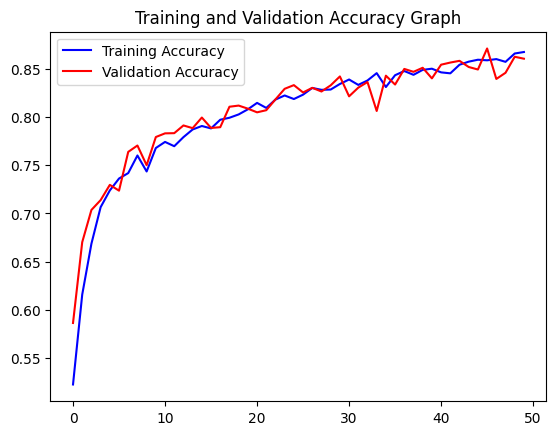

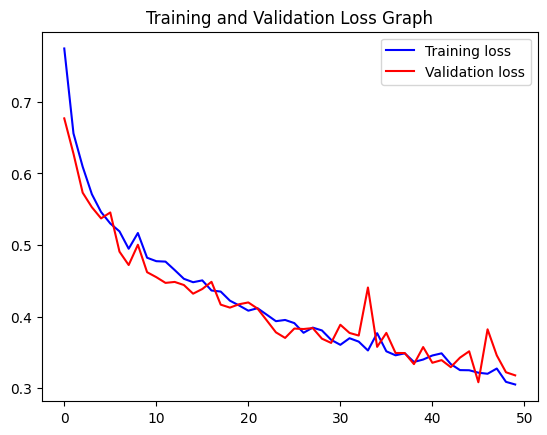

In [18]:
#Visualisation of results
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs,acc,'b',label='Training Accuracy')
plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
plt.title('Training and Validation Accuracy Graph')
plt.legend()
plt.figure()

loss=history.history['loss']
val_loss=history.history['val_loss']
plt.plot(epochs,loss,'b',label='Training loss')
plt.plot(epochs,val_loss,'r',label='Validation loss')
plt.title('Training and Validation Loss Graph')
plt.legend()
plt.show()


In [20]:
model.save("my_model.h5")   # or any name you like, e.g., "dog_cat_model.h5"

In [21]:
from tensorflow.keras.models import load_model
model = load_model("my_model.h5")

In [22]:
#Test With Real Image

In [26]:
image_path = r"D:\Projects ML\Dog Vs Cats Classifire Proj 6\test_cat.jpg"
img = load_img(image_path, target_size=(128, 128))
img = np.array(img)
img = img / 255.0 # normalize the image
img = img.reshape(1, 128, 128, 3) # reshape for prediction
pred = model.predict(img)
if pred[0] > 0.5:
    label = 'Dog'
else:
    label = 'Cat'
print(label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Cat


In [27]:
image_path = r"D:\Projects ML\Dog Vs Cats Classifire Proj 6\test_dog.jpeg"
img = load_img(image_path, target_size=(128, 128))
img = np.array(img)
img = img / 255.0 # normalize the image
img = img.reshape(1, 128, 128, 3) # reshape for prediction
pred = model.predict(img)
if pred[0] > 0.5:
    label = 'Dog'
else:
    label = 'Cat'
print(label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Dog
